In [2]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import cv2
from qiskit import QuantumCircuit , transpile
from qiskit_aer import AerSimulator
import pennylane as qml
from pennylane import numpy as np
import numpy as pop
import quimb.tensor as qtn

2026-02-13 00:38:32.623689: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-13 00:38:32.721333: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-13 00:38:36.242898: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [14]:
SIZE = 256
img = cv2.imread( "/home/adminpc/Documents/Professors_Diary/QuantumnComputing/qenv/Qunatumcomputingalgos/Quantumn_image_reconstruction/Images_for_classification/monalisa.jpg"
)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (SIZE, SIZE))
img_data = []
img_data.append(pop.array(img)) # Using np.array instead of undefined img_to_array
img_array = pop.reshape(img_data, (len(img_data), SIZE, SIZE, 1))
img_array = img_array.astype('float32')
img_array /= 255.0
flat = img_array.flatten() # flatten data array
print("the flatten numapy image arry is " , flat)
x = flat
print(x.size)

## lets flatten the image array i gues it is already falltened to float 32 so 



the flatten numapy image arry is  [0.4117647  0.3019608  0.41568628 ... 0.03137255 0.07058824 0.26666668]
65536


In [16]:
import numpy as np
import quimb.tensor as qtn

x = np.asarray(x, dtype=np.float64).ravel()
x = x / np.linalg.norm(x)

# 4096 = 2^12
dims = [2] * 16
mps = qtn.MatrixProductState.from_dense(x, dims=dims)
mps.compress(max_bond=40, cutoff=1e-8)

img_array_reconstructed = np.asarray(mps.to_dense()).ravel()

error_reconstruction = (
    np.linalg.norm(x - img_array_reconstructed) / np.linalg.norm(x)
)

print("max bond after compression:", max(mps.bond_sizes()))
print("relative reconstruction error:", error_reconstruction)


max bond after compression: 40
relative reconstruction error: 0.0849652065588555


MPS relative reconstruction error: 0.06400574234747163
latent shape: (1, 16)
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.2468
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.2466
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2465
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2463
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2461
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2459
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2457
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2455
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2453
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2451
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2449
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2446
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2443
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2440
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━

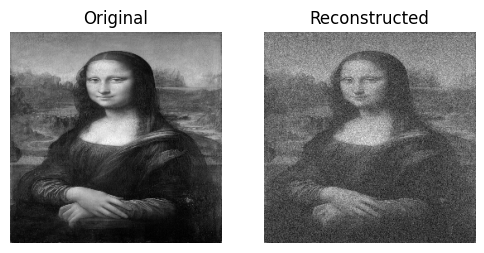

In [ ]:
import numpy as np
import quimb.tensor as qtn
import pennylane as qml
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# x must be flattened 256x256 grayscale

# 1) MPS compress + reconstruct (2^16)
mps = qtn.MatrixProductState.from_dense(x, dims=[2] * 16)
mps.compress(max_bond=64, cutoff=1e-8)

x_mps = np.asarray(mps.to_dense()).ravel()
x_mps = x_mps / (np.linalg.norm(x_mps) + 1e-12)

err = np.linalg.norm(x - x_mps) / np.linalg.norm(x)
print("MPS relative reconstruction error:", err)

# 2) Quantum latent (16 features)
n_qubits = 16
n_layers = 5
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qae(amplitudes, weights):
    qml.AmplitudeEmbedding(amplitudes, wires=range(n_qubits), normalize=True)
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weights = qml.numpy.array(
    0.01 * np.random.randn(n_layers, n_qubits, 3), requires_grad=True
)

latent = np.array(qae(x_mps, weights), dtype=np.float32).reshape(1, n_qubits)
print("latent shape:", latent.shape)

# 3) Decoder for 256x256x1
decoder = models.Sequential([
    layers.Input(shape=(n_qubits,)),
    layers.Dense(128, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(2048, activation="relu"),
    layers.Dense(256 * 256, activation="sigmoid"),
    layers.Reshape((256, 256, 1))
])

decoder.compile(optimizer="adam", loss="mse")

target = x.reshape(1, 256, 256, 1).astype(np.float32)

history = decoder.fit(latent, target, epochs=200, verbose=1)
pred = decoder.predict(latent)

# 4) Plot
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(target[0, :, :, 0], cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Reconstructed")
plt.imshow(pred[0, :, :, 0], cmap="gray")
plt.axis("off")
plt.show()
